## notes

* Better without "spin"?

# LLearn Analysis

This is a short data analysis notebook for the Laundry Learn project. I take a look into the data and maybe play around with some machine learning algorithms

## import and chdir

In [1]:
import glob, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir("logs/")


## fetch and sort data

Read all .log files from directory and pass important values to array.
This array consists of:
* Starttime as UNIX Timestamp (int)
* Setting of Rotary (0-23)
* Setting of Spin (0-3)
* Short-Laundry Setting (bool)
* Maximum Shake Value (float)
* Minimum Shake Value (float)
* Length of Run (int)

In [2]:
llearn_data = []
for filename in glob.glob("*.log"):
    item = {}
    file = pd.read_csv(filename)
    # get settings
    item["starttime"] = int(filename.rstrip(".log"))
    item["rotary"] = file["rotary"][0]
    # spin
    item["spin"] = 0 if (file["a1"][0] == 1) else (1 if (file["a2"][0] == 1) else 2)
    item["short"] = file["a6"][0]
    item["maxShake"] = file["shake"].max()
    item["minShake"] = file["shake"].min()
    item["duration"] = int(file["time"].iloc[-1:])
    item["maxpower"] = int(file["s0"].iloc[-1:])
    llearn_data.append(item)
llearnpd = pd.DataFrame.from_records(llearn_data)
rot_nums = np.unique(llearnpd.rotary)

In [3]:
def deriveMeanValueRemap(data, array):
    dictmap = {}
    for i in array:
        item = {}
        duration = None
        for dfi in data:
            if dfi['rotary'] == i:
                if duration == None:
                    duration = dfi['duration']
                else:
                    duration = (duration + dfi['duration']) / 2
        item['meanDuration'] = duration
        dictmap[i] = item
    dictmap = sorted(dictmap.items(), key=lambda k: k[1]['meanDuration'])
    remap = {}
    for i in range(0, len(dictmap)):
        remap[dictmap[i][0]] = i
    return remap

def renameRotaryValues(source, remap):
    for i in source:
        i['rotary'] = remap[i['rotary']]
    return source

remap = deriveMeanValueRemap(llearn_data, rot_nums)
llearn_data = renameRotaryValues(llearn_data, remap)
llearnpd = pd.DataFrame.from_records(llearn_data)


## load matplotlib and show data histograms

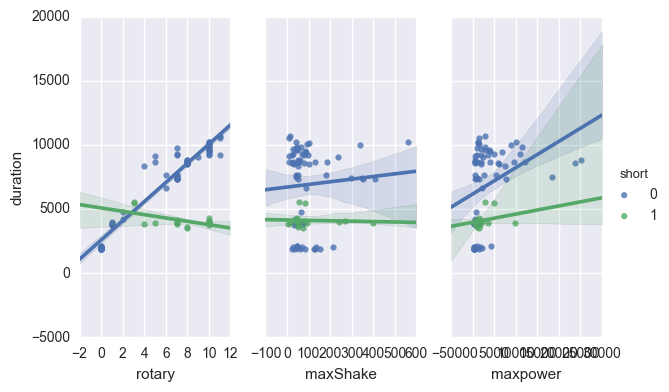

In [4]:
%matplotlib inline
# p = llearnpd.plot.scatter(x="rotary", y="duration", c="short")
sns.pairplot(llearnpd, x_vars=['rotary', 'maxShake', 'maxpower'], y_vars='duration', size=4, aspect=0.5, kind='reg', hue='short', diag_kind="kde")
# sns.pairplot(llearnpd)
# llearnpd.hist(bins=50, figsize=(30,25))
# plt.show()

## Going into Linear Regression

### split set into X and y

In [5]:
# Prepare feature set of relevant settings

X = llearnpd[["rotary", "short"]] # , "spin", "short"
X.head()

,rotary,short
0,7,0
1,8,0
2,8,0
3,1,0
4,10,1


In [6]:
# Prepare y
y = llearnpd["duration"]
y.head()

0    7336
1    8604
2    8854
3    3757
4    3926
Name: duration, dtype: int64

### split training and test sets

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### linear regression with scikit*

In [8]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### make a predition

In [9]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [10]:
from sklearn import metrics

### calculate errors

In [11]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

599.599181206


In [12]:
print(np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))

20.0682752018


### playground

In [30]:
testitem = pd.DataFrame.from_records([{'rotary': 1, 'short': 0}]) # , 'spin': 0, 'short': 0
linreg.predict(testitem)

array([ 3763.69878013])